In [3]:
import cv2
import os
import imutils
from imutils.contours import sort_contours
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from PIL import Image
from itertools import groupby
from IPython.display import Image as disp
from IPython.display import display

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import glorot_uniform #The goal of Xavier Initialization is to initialize the weights such that the variance of the activations are the same across every layer. This constant variance helps prevent the gradient from exploding or vanishing.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [ ]:
!unzip -qo data_berke.zip

#DATA PREPARATION AND PREPROCESS

In [ ]:
datadir = 'data/dataset'
x = []
y = []
for f in os.listdir(datadir):
    p = os.path.join(datadir, f)
    for imgs in os.listdir(p):
        img = cv2.imread(os.path.join(p, imgs))
        x.append(img)
        y.append(f)
print('LABELS')
print(list(set(y)))

LABELS
['2', '8', '6', '0', '4', 'sub', 'add', '3', 'equals', '1', '9', 'rp', 'lp', '7', '5', 'times']


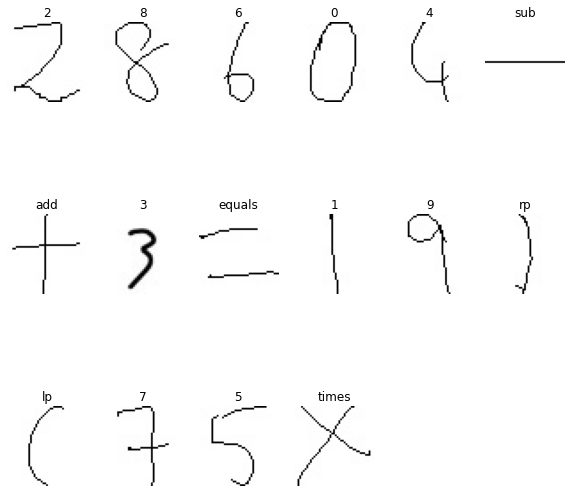

In [ ]:
fig = plt.figure(figsize=(10, 10))
label_count = 0
unique_labels = list(set(y))
for label in unique_labels:
    # Find the first occurrence of the current label in the y list
    image_index = y.index(label)+14
    # Get the corresponding image
    image = x[image_index]
    # Add a subplot for the image
    fig.add_subplot(3, 6, label_count+1)
    # Display the image
    plt.imshow(image)
    # Turn off the axis labels
    plt.axis('off')
    # Set the title of the subplot to the label
    plt.title(label)
    # Increment the label counter
    label_count += 1

###VISUALIZING DATA

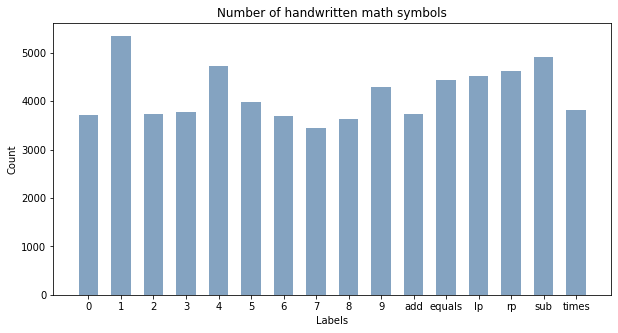

In [ ]:
fig = plt.figure(figsize=(10, 5))
unique,count = np.unique(y, return_counts=True)
# creating the bar plot
plt.bar(unique, count, color=(0.2, 0.4, 0.6, 0.6), width = 0.6)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Number of handwritten math symbols")
plt.show()

###Processing images with Otsu's thresholding

In [ ]:
X = []
for i in range(len(x)):
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    X.append(threshold_image)
print(len(X))

66387


###Encoding labels

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))

66387


In [ ]:
X = np.array(X)
y = np.array(y)

X = X[..., np.newaxis]
y = to_categorical(y)


X = X / 255.

print(X.shape)
print(y.shape)

(66387, 45, 45, 1)
(66387, 16)


###SPLITTING DATA

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
for train_index, test_index in kfold.split(X):
    # Split the data into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

LENET-5 ARCHITECTURE WITH SOME CHANGES

In [ ]:
regularizer = l2(0.01)
model = Sequential()
model.add(Input(shape=(45, 45, 1)))

#Layer 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',kernel_initializer=glorot_uniform(seed=0),activation='relu',name='conv1', activity_regularizer=regularizer))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

#Layer2
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',kernel_initializer=glorot_uniform(seed=0),activation='relu', name='conv2', activity_regularizer=regularizer))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

#Layer3
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same',kernel_initializer=glorot_uniform(seed=0),activation='relu',name='conv3', activity_regularizer=regularizer))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

# Fully connected layer 1
model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='FC1'))
model.add(BatchNormalization())
# Fully connected layer 2
model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='FC2'))
model.add(BatchNormalization())
# Output layer
model.add(Dense(16, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='FC3'))

# Compile the model
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 45, 45, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2 (Conv2D)              (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 5, 5, 64)        

In [ ]:
checkpoint = ModelCheckpoint('maths_symbol_and_digits_recognition.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')
callbacks = [checkpoint]

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/20
415/415 [==============================] - ETA: 0s - loss: 0.7028 - accuracy: 0.8175
Epoch 1: val_loss improved from inf to 1.78747, saving model to maths_symbol_and_digits_recognition.h5
415/415 [==============================] - 198s 477ms/step - loss: 0.7028 - accuracy: 0.8175 - val_loss: 1.7875 - val_accuracy: 0.4194
Epoch 2/20
415/415 [==============================] - ETA: 0s - loss: 0.2554 - accuracy: 0.9268
Epoch 2: val_loss improved from 1.78747 to 0.49112, saving model to maths_symbol_and_digits_recognition.h5
415/415 [==============================] - 201s 483ms/step - loss: 0.2554 - accuracy: 0.9268 - val_loss: 0.4911 - val_accuracy: 0.8553
Epoch 3/20
415/415 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9452
Epoch 3: val_loss improved from 0.49112 to 0.33282, saving model to maths_symbol_and_digits_recognition.h5
415/415 [==============================] - 186s 449ms/step - loss: 0.1896 - accuracy: 0.9452 - val_loss: 0.3328 - val_accurac

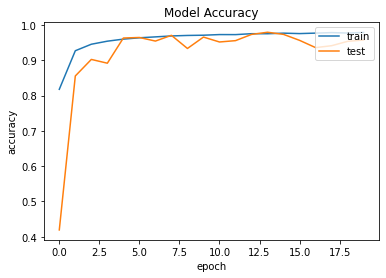

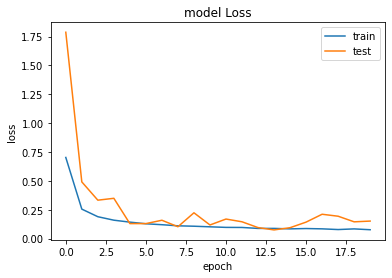

In [ ]:
# history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [48]:
yprediction = model.predict(X_test)
yprediction = np.argmax(yprediction, axis=1)
Y_test_hat = np.argmax(y_test, axis=1)
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)
print(' ')
print(classification_report(Y_test_hat, yprediction))

104/104 [==============================] - 10s 98ms/step - loss: 0.1517 - accuracy: 0.9571
test loss, test acc: [0.15171794593334198, 0.9571439623832703]
 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       739
           1       0.83      0.96      0.89      1046
           2       0.99      0.94      0.97       779
           3       0.97      0.98      0.98       779
           4       0.95      0.95      0.95       930
           5       0.99      0.97      0.98       799
           6       0.99      0.94      0.96       737
           7       0.97      0.96      0.97       680
           8       1.00      0.85      0.92       719
           9       0.99      0.90      0.94       863
          10       0.95      0.98      0.97       746
          11       1.00      0.97      0.98       904
          12       0.91      0.95      0.93       928
          13       0.94      0.96      0.95       880
          14       0.98      1.00

In [ ]:
model.save('model_FINAL.h5')

In [98]:
def prediction_and_calculator(path):

  image = Image.open(path).convert("L")

  weight = image.size[0]
  height = image.size[1]
  ratio = weight / height
  new_weight = int(ratio * 45)
  new_height = 45

  image_last = image.resize((new_weight, new_height))

  img_to_arr = np.array(image_last)

  image_arr_inv = 255 - img_to_arr

  prep_img = image_arr_inv / 255.0

  'splitting image array into individual digit arrays using non zero columns'
  mask = prep_img.any(0)
  out = [prep_img[:,[*g]] for k, g in groupby(np.arange(len(mask)), lambda x: mask[x] != 0) if k]

  list_version = []

  # Iterate through each element array
  for element in out:
    # Calculate number of filler columns needed
    num_fillers = prep_img.shape[0] - element.shape[1]

    # Calculate number of left and right filler columns needed
    num_left_fillers = num_fillers // 2
    num_right_fillers = num_fillers // 2
    if num_fillers % 2 == 1:
      num_right_fillers += 1

    # Create left and right filler arrays
    left_fillers = np.zeros((prep_img.shape[0], num_left_fillers))
    right_fillers = np.zeros((prep_img.shape[0], num_right_fillers))

    # Concatenate left and right fillers with element array to create final element array
    element_arr = np.concatenate((left_fillers, element, right_fillers), axis=1)

    # Resize element array and add it to list of elements
    element_arr.resize(45, 45, 1)
    list_version.append(element_arr)


  array_version = np.array(list_version)

  'reshaping to fit model input criteria'
  array_version = array_version.reshape(-1, 45, 45, 1)

  'predicting using the model'
  model = keras.models.load_model("/content/model_FINAL.h5")
  predicted_digits =  model.predict(array_version)
  predicted_digits = np.argmax(predicted_digits, axis = 1)


  operators = {10: "+", 11: "=", 12: "(", 13: ")", 14: "-", 15: "x"}

  # Initialize list to store separated elements
  elements = []
  temp = []

  # Iterate through each element
  for item in predicted_digits:
    # If item is not an operator, add it to the temporary list
    if item not in operators:
      temp.append(item)
    # If item is an operator, append the temporary list to the elements list and add the operator to the elements list
    else:
      elements.append(temp)
      elements.append(operators[item])
      temp = []

  # If there are remaining elements in the temporary list, append it to the elements list
  if temp:
    elements.append(temp)

  # Iterate through each element in the elements list
  for i, item in enumerate(elements):
    # If the element is a list (i.e. a group of digits), convert it to a single number
    if isinstance(item, list):
      num = 0
      for j, digit in enumerate(item):
        num += digit * (10 ** (len(item) - j - 1))
      elements[i] = str(num)
    # If the element is an operator, convert it to a string
    else:
      elements[i] = str(item)

  separator = ' '
  elementstring = separator.join(elements)
  print('What you have written looks like this : '+ elementstring)

  while True:
      try:
        ans = eval(elementstring)
        result  = elementstring + " = " + str(ans)
        print(result)
        break

      except:
        print("Invalid expression")
        break

#TAKEN PHOTO

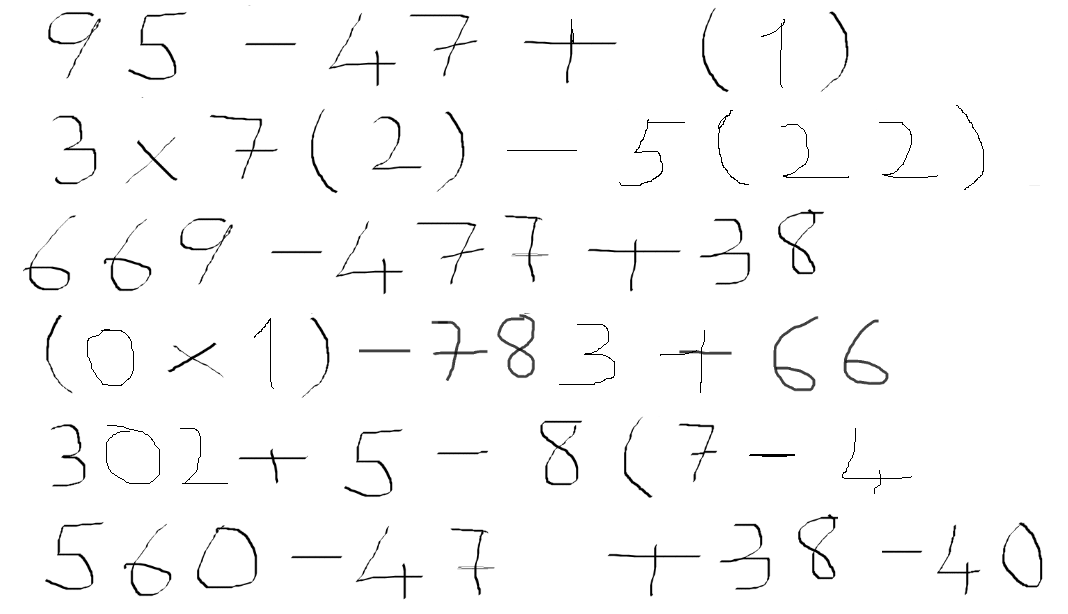

In [105]:
display(disp(filename="/content/samples.PNG"))

#SPLITTING IMAGE IN SUB ROW IMAGES

In [101]:
path_to_image = '/content/samples.PNG'
image = cv2.imread(path_to_image)
(h, w) = image.shape[:2]
heightX, heightY = (w), (h//6)

img1 = image[0:heightY,           2:heightX]
img2 = image[heightY:heightY*2,   2:heightX]
img3 = image[heightY*2:heightY*3, 2:heightX]
img4 = image[heightY*3:heightY*4, 2:heightX]
img5 = image[heightY*4:heightY*5, 2:heightX]
img6 = image[heightY*5:heightY*6, 2:heightX]

directory = r'/content/samples'
if not os.path.exists(directory):
    os.makedirs(directory)

# Saving the images to the directory
cv2.imwrite(os.path.join(directory, 'image1.PNG'), img1)
cv2.imwrite(os.path.join(directory, 'image2.PNG'), img2)
cv2.imwrite(os.path.join(directory, 'image3.PNG'), img3)
cv2.imwrite(os.path.join(directory, 'image4.PNG'), img4)
cv2.imwrite(os.path.join(directory, 'image5.PNG'), img5)
cv2.imwrite(os.path.join(directory, 'image6.PNG'), img6)

True

#DISPLAYING IMAGES AND PREDICTIONS

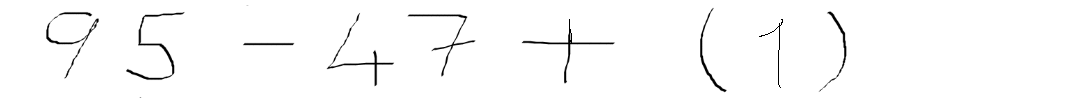

 
1/1 [==============================] - 0s 112ms/step
What you have written looks like this : 95 - 47 + 0 ( 1 )
Invalid expression


<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?


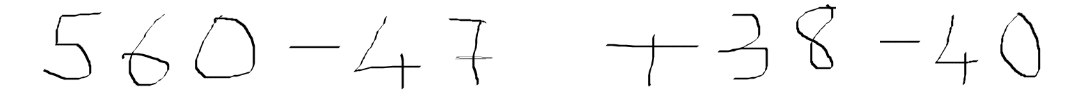

 
1/1 [==============================] - 0s 128ms/step
What you have written looks like this : 560 - 47 + 38 - 40
560 - 47 + 38 - 40 = 511


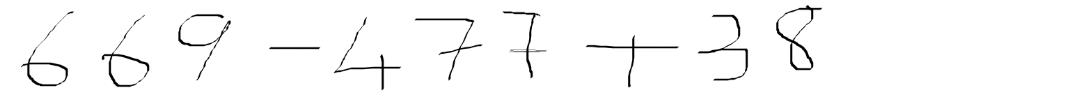

 
1/1 [==============================] - 0s 129ms/step
What you have written looks like this : 669 - 477 + 38
669 - 477 + 38 = 230


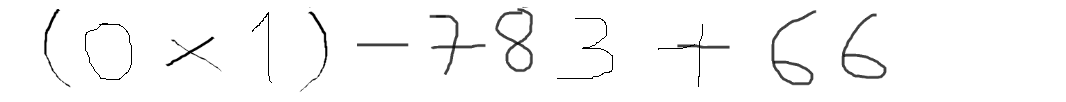

 
1/1 [==============================] - 0s 123ms/step
What you have written looks like this : 10 x 1 ) 0 - 783 + 66
Invalid expression


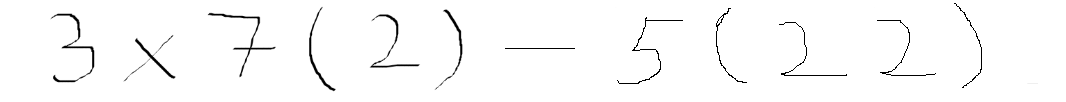

 
1/1 [==============================] - 0s 124ms/step
What you have written looks like this : 3 x 7 ( 2 ) 0 - 5 ( 22 ) 1
Invalid expression


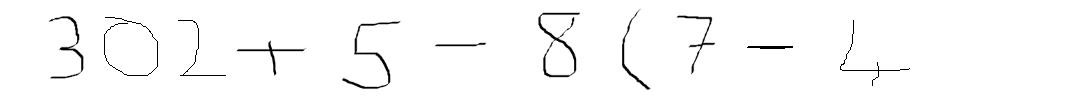

 
1/1 [==============================] - 0s 115ms/step
What you have written looks like this : 302 + 5 - 8817 - 4
302 + 5 - 8817 - 4 = -8514


In [102]:
folder_dir = "/content/samples"
for images in os.listdir(folder_dir):
    display(disp(filename=f"/content/samples/{images}"))
    print(' ')
    prediction_and_calculator(f"/content/samples/{images}")